# Example Notebook

This notebook provides an example in getting started with Stellar dataset. The notebook assumes that you have already familiarized yourself with the [README.md](https://github.com/stellar-gen-ai/stellar-dataset). 

The README.md contains instructions on how to download and process the dataset. After you have done so, you should have a folder, let's say output_dir, with the following structure:

    .
    ├── ...
    ├── output_dir                           # The datasets folder
    │   ├── STELLAR                          # The Stellar dataset folder
    │   │   ├── 000                          # Zeroth subject folder
    │   │   │   ├── 0.jpg                    # First image file
    │   │   │   ├── 0_bg.png                 # First image mask file
    │   │   │   ├── 0_attributes.json        # First image celeba annotations
    │   │   │   ├── 1.jpg                    # Second image file
    │   │   │   ├── 1_bg.png                 # Second image mask file
    │   │   │   ├── 1_attributes.json        # Second image celeba annotations
    │   │   │   ├── prompts_h.json           # Prompts-H file (only on test split)
    │   │   │   ├── prompts_t.json           # Prompts-T file
    │   │   │ ...
    └── ...

## Visualizing the dataset

In [1]:
import json
from collections import defaultdict
from itertools import chain
from os.path import join as pjoin

import numpy as np
import pandas as pd
import seaborn as sns
from flair.data import Sentence
from flair.nn import Classifier
from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
data_dict = {
    "stellar_h": [],
    "stellar_t": [],
}

for name in data_dict:
    with open(
        pjoin(
            "prompts",
            "{}.json".format(name),
        ),
        "r",
    ) as fp:
        data_dict[name] = json.load(fp)

prompts_dict = defaultdict(list)
for name, data in data_dict.items():
    prompts_dict[name] = [
        p.strip().replace("{}", "A person")
        for p in chain.from_iterable([dt["prompts"] for dt in data.values()])
    ]

### Prompt Stats

In [5]:
def prompts_stats(ds_name, prompts, plot_graph=True):
    prompts_len = np.array([len(prompt.split()) for prompt in prompts])
    unique_tokens = set(
        token for prompt in prompts for token in prompt.split()
    )
    if plot_graph:
        sns.histplot(
            prompts_len, discrete=True, kde=True, stat="density", kde_kws={'bw_method':1}
        )
        # sns.kdeplot(prompts_len, bw_method=1)
        plt.xlim(min(prompts_len), 20)

    print(f"Dataset {ds_name}")
    print(f"\tNumber of prompts: {len(prompts_len)}")
    print(f"\tAverage prompt length is: {prompts_len.mean()}")
    print(f"\tMedian prompt length is: {np.median(prompts_len)}")
    print(f"\tMax prompt length is: {prompts_len.max()}")
    print(f"\tMin prompt length is: {prompts_len.min()}")
    print(f"\tNumber of unique tokens: {len(unique_tokens)}")

Dataset stellar_h
	Number of prompts: 10000
	Average prompt length is: 8.8993
	Median prompt length is: 9.0
	Max prompt length is: 41
	Min prompt length is: 3
Dataset stellar_t
	Number of prompts: 10400
	Average prompt length is: 8.521057692307693
	Median prompt length is: 8.0
	Max prompt length is: 17
	Min prompt length is: 3


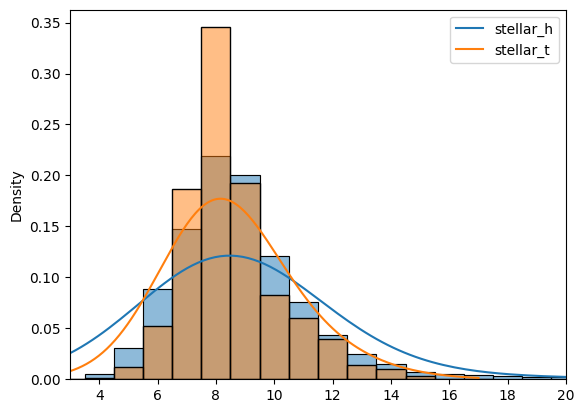

In [6]:
for ds_name, prompts in prompts_dict.items():
    prompts_stats(ds_name, prompts, plot_graph=True)
    plt.legend(prompts_dict.keys())

### POS (Part of Speech) Stats

In [28]:
def pos_stats(prompts, pos_tagger=None, print_results=True):
    if pos_tagger is None:
        pos_tagger = Classifier.load("upos")
    sentences = [Sentence(prompt) for prompt in prompts]
    for sentence in tqdm(sentences, disable=not print_results):
        pos_tagger.predict(sentence)

    pos_stats = {
        str(lbl.decode("utf-8")): []
        for lbl in pos_tagger.label_dictionary.item2idx.keys()
        if not str(lbl.decode("utf-8")).startswith("<")
    }
    for _, sentence in enumerate(sentences):
        for pos_key in pos_stats:
            pos_stats[pos_key].append([])
        for wd in sentence.get_labels("upos"):
            if wd.value not in pos_stats:
                continue
            pos_stats[wd.value][-1].append(wd.data_point.text)

    if print_results:
        for pos_type, pos_values in pos_stats.items():
            print(
                "\t{: <10}".format(pos_type),
                "{: <8}".format(np.array([len(wds) for wds in pos_values]).mean().round(3)),
                "{: <8}".format(len(set(chain.from_iterable(pos_values))))
            )

    return pos_stats

#### Per Prompt Stats

In [10]:
for ds_name, prompts in prompts_dict.items():
    print(f"Dataset {ds_name}")
    pos_metadata = pos_stats(prompts)

Dataset stellar_h
2024-01-02 22:43:55,064 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, VERB, PUNCT, ADP, DET, PROPN, PRON, ADJ, ADV, CCONJ, PART, NUM, AUX, INTJ, SYM, X, <START>, <STOP>


100%|██████████| 10000/10000 [02:17<00:00, 72.90it/s]


	NOUN       3.076    3855    
	VERB       1.239    1399    
	PUNCT      0.209    104     
	ADP        1.298    98      
	DET        1.563    101     
	PROPN      0.269    1105    
	PRON       0.172    242     
	ADJ        0.293    827     
	ADV        0.078    203     
	CCONJ      0.044    31      
	PART       0.031    10      
	NUM        0.835    355     
	AUX        0.0      2       
	INTJ       0.007    47      
	SYM        0.002    15      
	X          0.001    7       
Dataset stellar_t
2024-01-02 22:46:14,446 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, VERB, PUNCT, ADP, DET, PROPN, PRON, ADJ, ADV, CCONJ, PART, NUM, AUX, INTJ, SYM, X, <START>, <STOP>


100%|██████████| 10400/10400 [02:12<00:00, 78.56it/s]


	NOUN       2.855    454     
	VERB       1.125    126     
	PUNCT      0.004    22      
	ADP        1.274    37      
	DET        1.626    21      
	PROPN      0.554    171     
	PRON       0.028    34      
	ADJ        0.073    52      
	ADV        0.031    17      
	CCONJ      0.001    1       
	PART       0.003    2       
	NUM        0.943    42      
	AUX        0.0      0       
	INTJ       0.003    8       
	SYM        0.003    4       
	X          0.0      1       


#### Per Identity Stats (for test split)

In [22]:
prompts_per_id_dict = defaultdict(list)
for name, data in data_dict.items():
    prompts_per_id_dict[name] = [
        [p.strip().replace("{}", "A person") for p in dt["prompts"]]
        for dt in data.values()
    ]

In [36]:
merged = {
    ds_name: defaultdict(list)
    for ds_name in prompts_per_id_dict.keys()
}

pos_tagger = Classifier.load("upos")

for ds_name, prompts_per_id in prompts_per_id_dict.items():
    print(f"Dataset {ds_name}")

    for idx, id_prompts in enumerate(tqdm(prompts_per_id[:200])):
        pos_metadata = pos_stats(id_prompts, pos_tagger, print_results=False)
        for key in pos_metadata.keys():
            merged[ds_name][key].append(list(chain.from_iterable(pos_metadata[key])))

2024-01-02 23:30:54,121 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, VERB, PUNCT, ADP, DET, PROPN, PRON, ADJ, ADV, CCONJ, PART, NUM, AUX, INTJ, SYM, X, <START>, <STOP>
Dataset stellar_h


100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


Dataset stellar_t


100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


In [37]:
for ds_name, merged_i in merged.items():
    print(f"Dataset {ds_name}")

    for pos_type, pos_values in merged_i.items():
        print(
            "\t{: <10}".format(pos_type),
            "{: <8}".format(np.array([len(set(wds)) for wds in pos_values]).mean().round(3)),
            "{: <8}".format(len(set(chain.from_iterable(pos_values))))
        )

Dataset stellar_h
	NOUN       97.48    3855    
	VERB       48.915   1399    
	PUNCT      2.45     104     
	ADP        17.23    98      
	DET        5.005    101     
	PROPN      13.155   1105    
	PRON       5.56     242     
	ADJ        13.775   827     
	ADV        3.755    203     
	CCONJ      1.2      31      
	PART       1.055    10      
	NUM        4.92     355     
	AUX        0.01     2       
	INTJ       0.36     47      
	SYM        0.11     15      
	X          0.035    7       
Dataset stellar_t
	NOUN       78.695   454     
	VERB       30.91    125     
	PUNCT      0.21     22      
	ADP        10.225   37      
	DET        4.355    21      
	PROPN      23.92    171     
	PRON       1.26     34      
	ADJ        3.34     52      
	ADV        1.035    17      
	CCONJ      0.05     1       
	PART       0.13     2       
	NUM        3.095    42      
	AUX        0.0      0       
	INTJ       0.13     8       
	SYM        0.14     4       
	X          0.005    1       


### Detectable Objects Stats

In [57]:
def objects_stats(ds_name, objects, plot_graph=True):
    objs_per_prompt = np.array([len(objs) for objs in objects])
    print(f"Dataset {ds_name}")
    print(f"\tAverage number of objects per prompt: {objs_per_prompt.mean()}")
    print(f"\tMedian number of objects per prompt: {np.median(objs_per_prompt)}")
    print(f"\tMax number of objects per prompt: {objs_per_prompt.max()}")
    print(f"\tMin number of objects per prompt: {objs_per_prompt.min()}")

    flat_objects = chain.from_iterable(objects)
    flat_objects = list(map(lambda x: x.lower(), flat_objects))
    print(f"\tNumber of unique nouns and names: {len(set(flat_objects))}")

    objects_df = pd.Series(flat_objects)

    # Get the value counts for the strings and select the top 100 most frequent
    top_objects = objects_df.value_counts()[1:51]

    # Convert the value counts to a DataFrame
    df = pd.DataFrame({'Object': top_objects.index, 'Frequency': top_objects.values})

    if plot_graph:
        # Create a Seaborn bar plot
        plt.figure(figsize=(10, 12))
        sns.barplot(x='Frequency', y='Object', data=df, palette='viridis')

    return objects_df.value_counts()

In [58]:
objects_t = list(
    chain.from_iterable(
        [dt["detectables"] for dt in data_dict["stellar_t"].values()]
    )
)

Dataset Stellar-T
	Average number of objects per prompt: 1.7782692307692307
	Median number of objects per prompt: 2.0
	Max number of objects per prompt: 3
	Min number of objects per prompt: 0
	Number of unique nouns and names: 418


/tmp/ipykernel_425896/2606607731.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Object', data=df, palette='viridis')


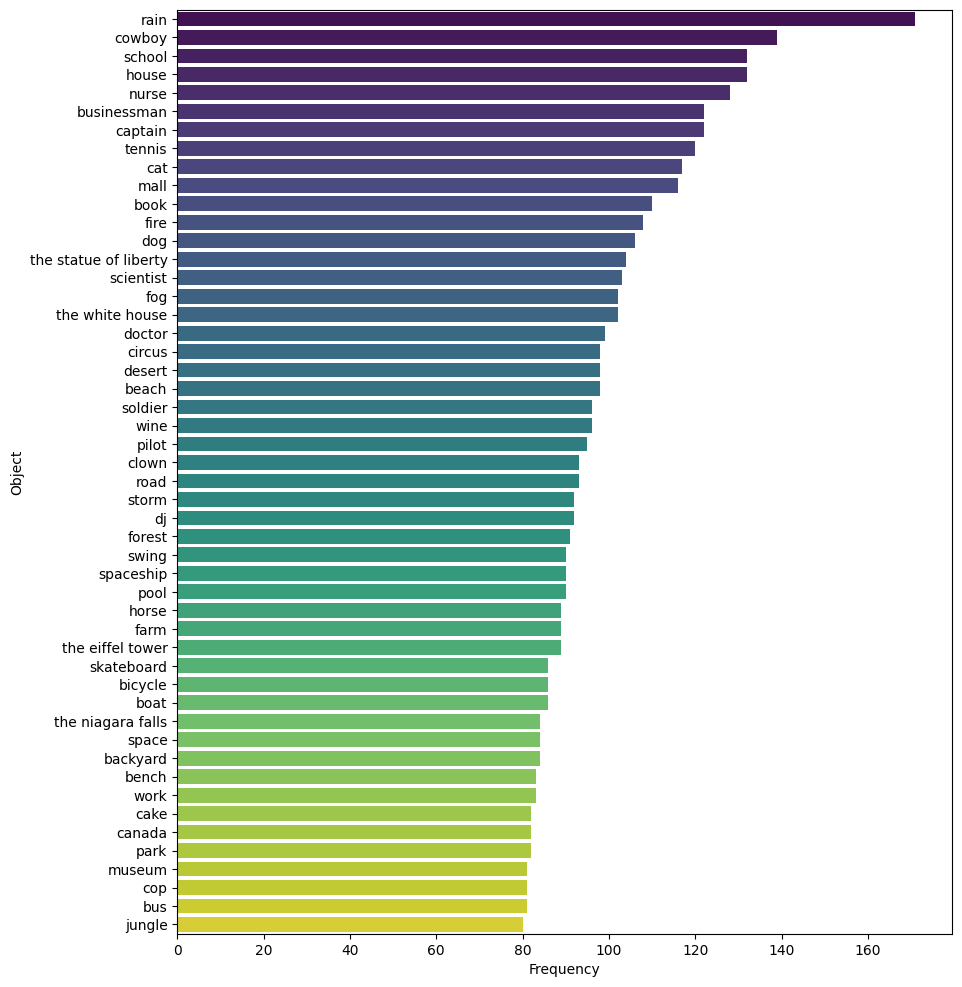

In [59]:
object_stats = objects_stats("Stellar-T", objects_t, plot_graph=True)

## Interacting with the provided PyTorch Dataset

In [ ]:
from stellar_dataset import Stellar

dataset = Stellar(pjoin("output_dir", "STELLAR"))

In [ ]:
sample = dataset[0]
print(sample)
sample["img"]

### Metadata

The metadata can be used for the evaluation of an image

In [ ]:
dataset.get_metadata(sample["index"])